Time series analysis is the preparatory step before developing a forecasting model.

Besides, time series forecasting has enormous commercial significance because stuff that is important to a business like demand and sales, number of visitors to a website, stock price, etc. are essentially time series data.

Time series analysis involves understanding various aspects about the inherent nature of the series so that we are better informed to create meaningful and accurate forecasts.

In [215]:
import random
from dateutil.parser import parse
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

### Import time series

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


### Panel data

Panel data is also a time based dataset.

The difference is that, in addition to time series, it also contains one or more related variables that are measured for the same time periods.

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv')
df = df.loc[df.market=='DELHI', :]
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
2013,DELHI,January,2003,246040,146,370,280,DEL,DELHI,January-2003
2014,DELHI,January,2004,206360,471,1065,928,DEL,DELHI,January-2004
2015,DELHI,January,2005,237510,212,551,489,DEL,DELHI,January-2005
2016,DELHI,January,2006,246900,390,598,541,DEL,DELHI,January-2006
2017,DELHI,January,2007,190560,808,1215,1022,DEL,DELHI,January-2007


### Visualizing a time series

               value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869


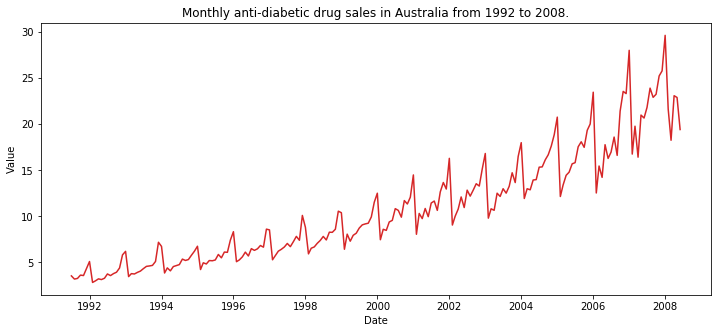

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
print(df.head())

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(12, 5))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

Since all values are positive, we can show this on both sides of the Y axis to emphasize the growth.

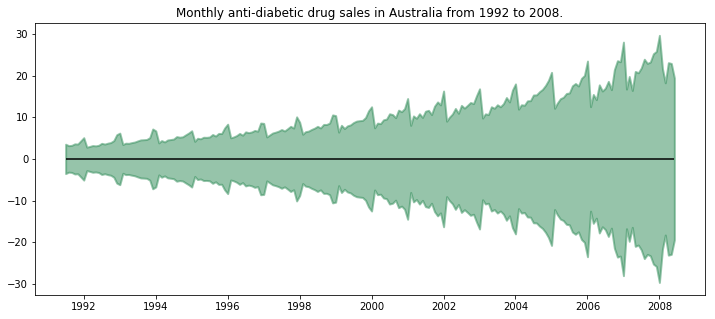

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.fill_between(df.index, y1=df.value, y2=-df.value, alpha=0.5, linewidth=2, color='seagreen')
plt.title('Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')
plt.hlines(y=0, xmin=df.index.min(), xmax=df.index.max(), linewidth=1.5)
plt.show()

### Seasonal Plot of a Time Series

Since its a monthly time series and follows a certain repetitive pattern every year, you can plot each year as a separate line in the same plot. This lets you compare the year wise patterns side-by-side.

In [38]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()
print('Years:', years)
df.head()

Years: [1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008]


,value,year,month
date,,,
1991-07-01,3.526591,1991,Jul
1991-08-01,3.180891,1991,Aug
1991-09-01,3.252221,1991,Sep
1991-10-01,3.611003,1991,Oct
1991-11-01,3.565869,1991,Nov


In [39]:
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
mycolors

array(['xkcd:vivid purple', 'xkcd:bright lavender', 'xkcd:sapphire',
       'xkcd:dark fuchsia', 'xkcd:dusky pink', 'xkcd:dusty purple',
       'xkcd:dark tan', 'xkcd:orange brown', 'xkcd:red orange',
       'xkcd:clear blue', 'xkcd:lemon', 'xkcd:bluish grey',
       'xkcd:dark blue grey', 'xkcd:pale violet', 'xkcd:orangey yellow',
       'xkcd:cool grey', 'xkcd:green', 'xkcd:ice'], dtype='<U31')

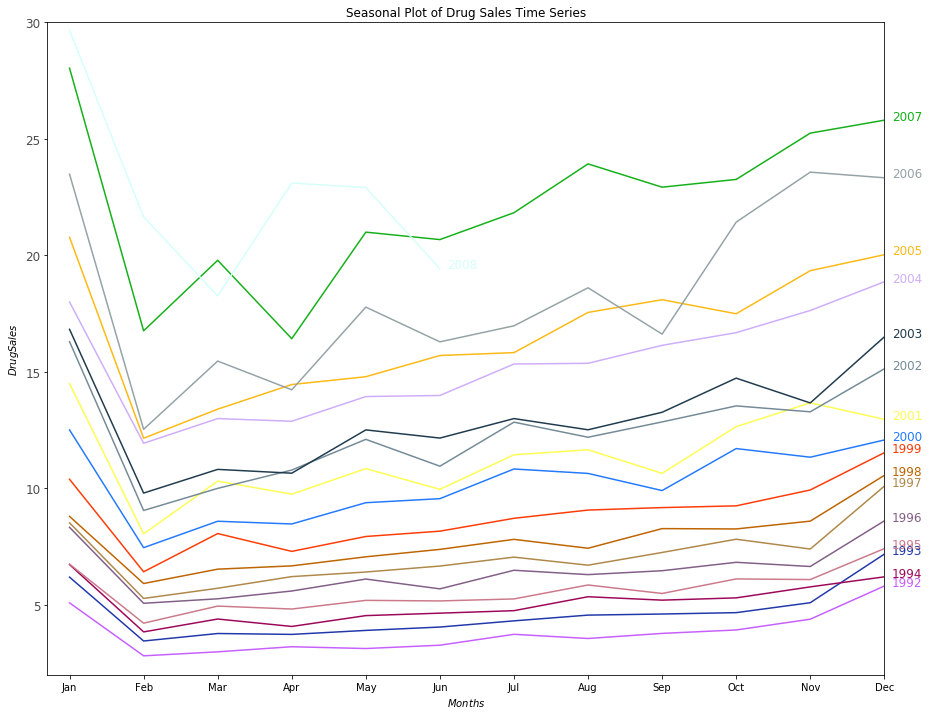

In [55]:
# Draw Plot
plt.figure(figsize=(15, 12))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Months$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series")
plt.show()

There is a steep fall in drug sales every February, rising again in March, falling again in April and so on. Clearly, the pattern repeats within a given year, every year.

However, as years progress, the drug sales increase overall. We can nicely visualize this trend and how it varies each year in a nice year-wise boxplot. Likewise, we can do a month-wise boxplot to visualize the monthly distributions.

### Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

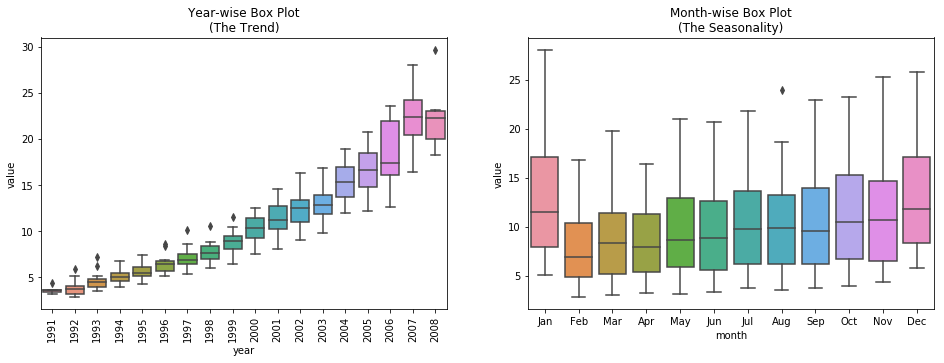

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :]) # To begin in january
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=12)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=12)
plt.show()

The boxplots make the year-wise and month-wise distributions evident. Also, in a month-wise boxplot, the months of December and January clearly has higher drug sales, which can be attributed to the holiday discounts season.

So far, we have seen the similarities to identify the pattern. Now, let's find out deviations from the usual pattern.

### Patterns in a time series

Any time series may be split into the following components: **Base Level + Trend + Seasonality + Error**

- **Base Level:** is the ground true signal without any bias.
- **Trend:** is observed when there is an increasing or decreasing slope observed in the time series.
- **Seasonality:** is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors.
- **Error:**: is the random variation (*noise*) in the series.

However, it's not a mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

So, a time series can be imagined as a combination of the trend, seasonality and the error terms.

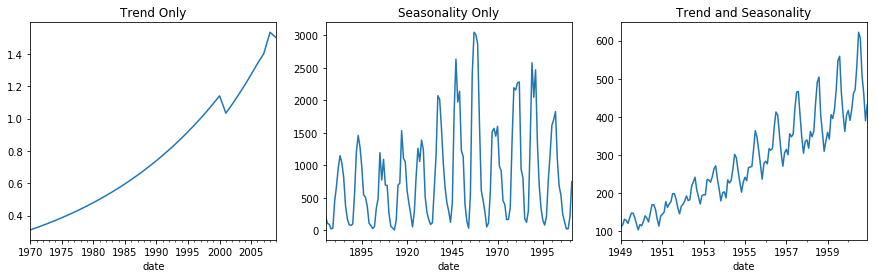

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

Another aspect to consider is the **cyclic** behaviour. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse *cyclic* effect with *seasonal* effect.

So, how to diffentiate between a *cyclic* vs *seasonal* pattern?

If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.

### Additive and multiplicative time series

Depending on the nature of the trend and seasonality, a time series can be modeled as an *additive* or *multiplicative*, wherein, each observation in the series can be expressed as either a *sum* or a *product* of the components:

- **Additive time series:** 

$Value = Base Level + Trend + Seasonality + Error$

- **Multiplicative Time Series:** 

$Value = Base Level * Trend * Seasonality * Error$

### How to decompose a time series into its components?

We can do a classical decomposition of a time series by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.

The `seasonal_decompose` function in `statsmodels` package implements this conveniently.

<Figure size 1080x1080 with 0 Axes>

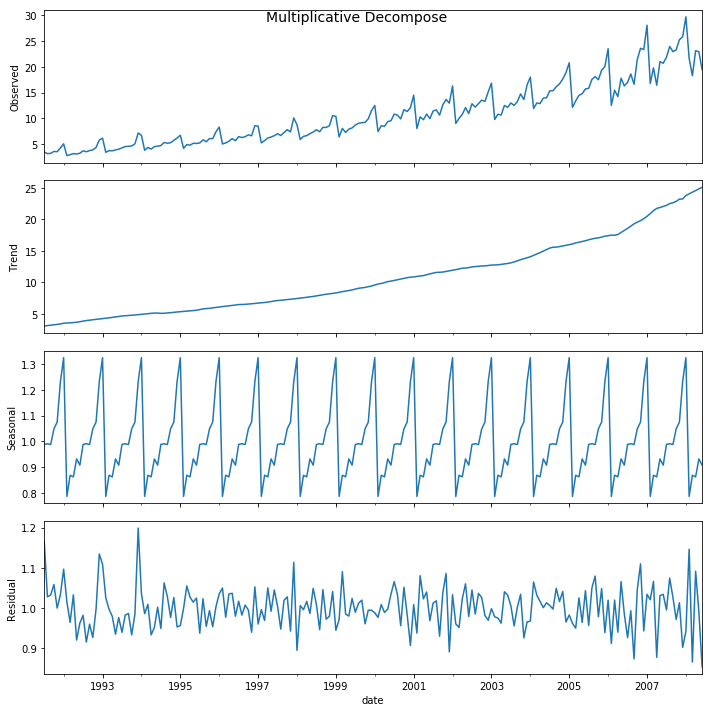

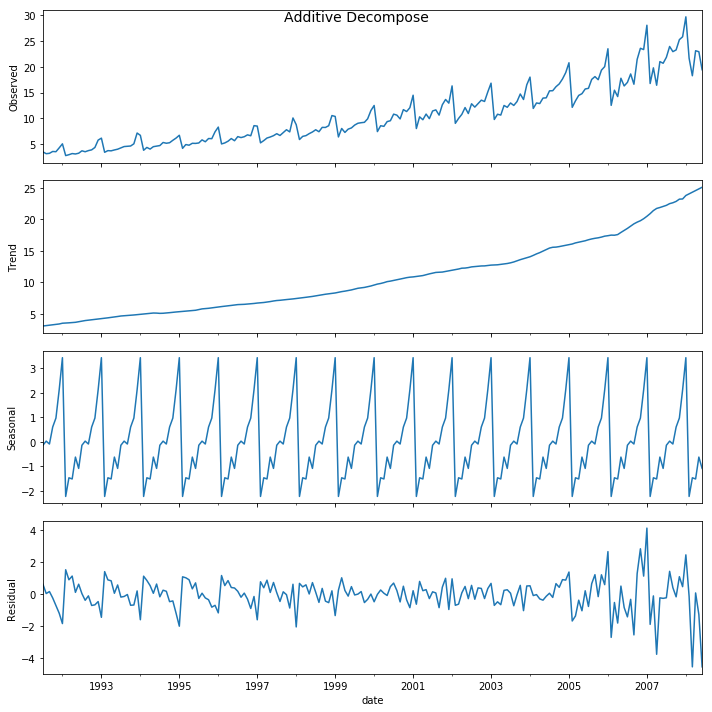

In [103]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.figure(figsize=(15, 15))
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=14)
result_add.plot().suptitle('Additive Decompose', fontsize=14)
plt.show()

Setting `extrapolate_trend='freq'` takes care of any missing values in the trend and residuals at the beginning of the series.

If we look at the residuals of the additive decomposition closely, it has some pattern left over. The multiplicative decomposition, however, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

The numerical output of the trend, seasonal and residual components are stored in the `result_mul` output itself. Let’s extract them and put it in a dataframe.

In [104]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


If we check, the product of `seas`, `trend` and `resid` columns should exactly equal to the actual values.

### Stationary and Non-Stationary Time Series

**Stationarity** is a property of a time series. 

A time series is stationary when its statistical properties do not depend on time. In order words, its mean, variance and autocorrelation are constant over time.

Most statistical forecasting methods are designed to work on a stationary time series.

So if a time series is non-stationary, it's possible to make it nearly stationary by applying a suitable transformation which can be:

- Differencing the Series (once or more)
- Take the log of the series
- Take the nth root of the series
- Combination of the above

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary. If the first difference doesn’t make a series stationary, we can go for the second differencing. And so on.

For example, consider the following series: [1, 5, 2, 12, 20]

First differencing gives: [5-1, 2-5, 12-2, 20-12] = [4, -3, 10, 8]

Second differencing gives: [-3-4, -10-3, 8-10] = [-7, -13, -2]

### Test for stationarity

The stationarity of a series can be established by looking at the plot of the series like we did earlier.

Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

Nevertheless, we need a quantitative method to determine if a given series is stationary or not. This can be done using statistical tests called **Unit Root Tests**. There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root.*

There are multiple implementations of Unit Root tests like:

1. **Augmented Dickey Fuller test (ADF Test)**
2. **Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)**
3. **Philips Perron test (PP Test)**

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is above a significance level (e.g 5%), we cannot reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using `statsmodels` package in python.

In [106]:
# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'\t{key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'\t{key}, {value}')

ADF Statistic: 3.14518568930673
p-value: 1.0
Critial Values:
	1%, -3.465620397124192
Critial Values:
	5%, -2.8770397560752436
Critial Values:
	10%, -2.5750324547306476

KPSS Statistic: 1.313675
p-value: 0.010000
Critial Values:
	10%, 0.347
Critial Values:
	5%, 0.463
Critial Values:
	2.5%, 0.574
Critial Values:
	1%, 0.739


C:\Users\dimitri.sifouakemgan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


### How to detrend a time series?

1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, we may want to use quadratic terms ($x^2$) in the model.
2. Subtract the trend component obtained from time series decomposition we saw earlier.
3. Subtract the mean
4. Apply a filter like *Baxter-King filter*(`statsmodels.tsa.filters.bkfilter`) or the *Hodrick-Prescott Filter* (`statsmodels.tsa.filters.hpfilter`) to remove the moving average trend lines or the cyclical components.

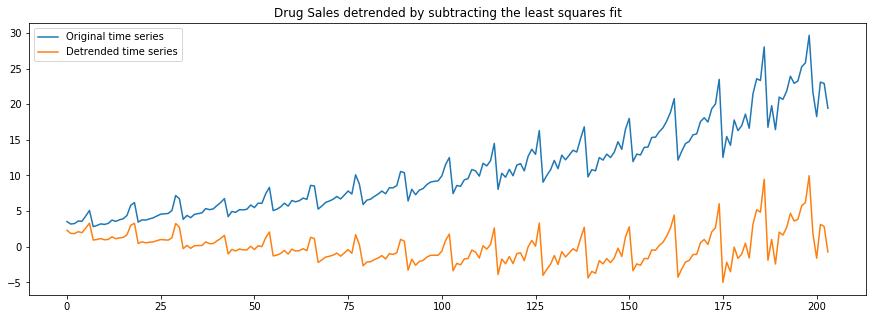

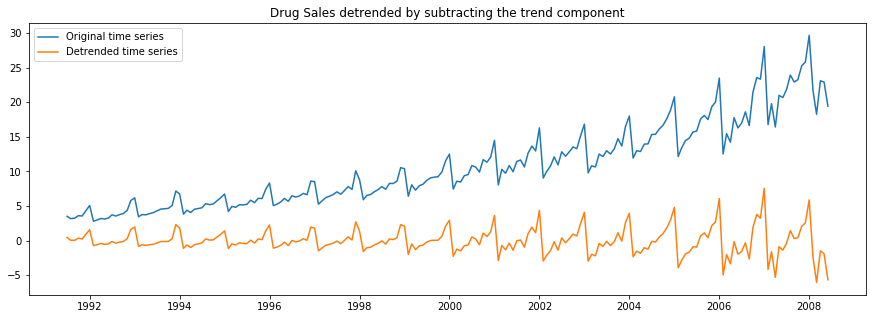

In [130]:
# Using scipy: Subtract the line of best fit
detrended = signal.detrend(df.value)

plt.figure(figsize=(15, 5))
plt.plot(df.value.values, label='Original time series')
plt.plot(detrended, label='Detrended time series')
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=12)
plt.legend()
plt.show()

# Using statmodels: Subtracting the Trend Component.
plt.figure(figsize=(15, 5))
detrended = df.value - result_mul.trend
plt.plot(df.value, label='Original time series')
plt.plot(detrended, label='Detrended time series')
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=12)
plt.legend()
plt.show()

### How to deseasonalize a time series?

1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.
2. Seasonal difference the series (subtract the value of previous season from the current value).
3. Divide the series by the seasonal index obtained from STL decomposition. If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. We can later restore to the original scale by taking an exponential.

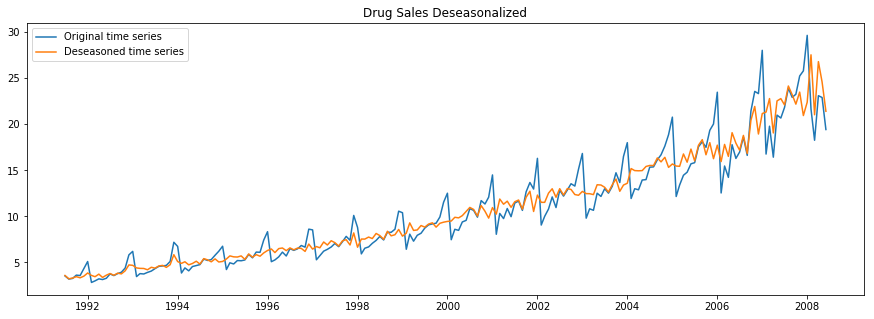

In [120]:
# Deseasonalize
deseasonalized = df.value.values / result_mul.seasonal

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df.value, label='Original time series')
plt.plot(deseasonalized, label='Deseasoned time series')
plt.title('Drug Sales Deseasonalized', fontsize=12)
plt.legend()
plt.show()

### How to test for seasonality of a time series?

The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar:

- Hour of day
- Day of month
- Weekly
- Monthly
- Yearly

However, if we want a more definitive inspection of the seasonality, we use the Autocorrelation Function (ACF) plot. When there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

> Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

For example, the drug sales time series is a monthly series with patterns repeating every year. So, we can see spikes at 12th, 24th, 36th.. lines.

Notice: In real word datasets, such strong patterns is hardly noticed and can get distorted by any noise, so we need a careful eye to capture these patterns.

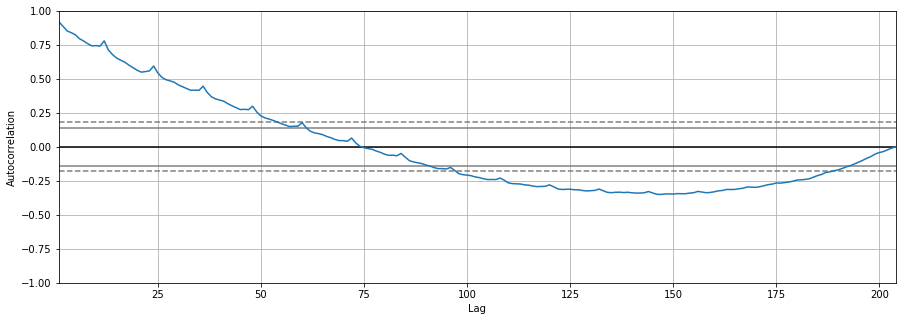

In [131]:
# Draw Plot
plt.figure(figsize=(15, 5))
pd.plotting.autocorrelation_plot(df.value.tolist())
plt.show()

### How to treat missing values in a time series?

Sometimes, the time series will have missing dates/times. That means, the data was not captured or was not available for those periods. It could so happen the measurement was zero on those days, in which case, case you may fill up those periods with zero.

Secondly, when it comes to time series, we should typically NOT replace missing values with the mean of the series, especially if the series is not stationary. What we could do instead for a quick and dirty workaround is to forward-fill the previous value.

However, depending on the nature of the series, we want to try out multiple approaches before concluding. Some effective alternatives to imputation are:

- Backward Fill
- Linear Interpolation
- Quadratic interpolation
- Mean of nearest neighbors
- Mean of seasonal couterparts

To measure the imputation performance, I manually introduce missing values to the time series, impute it with above approaches and then measure the mean squared error of the imputed against the actual values.

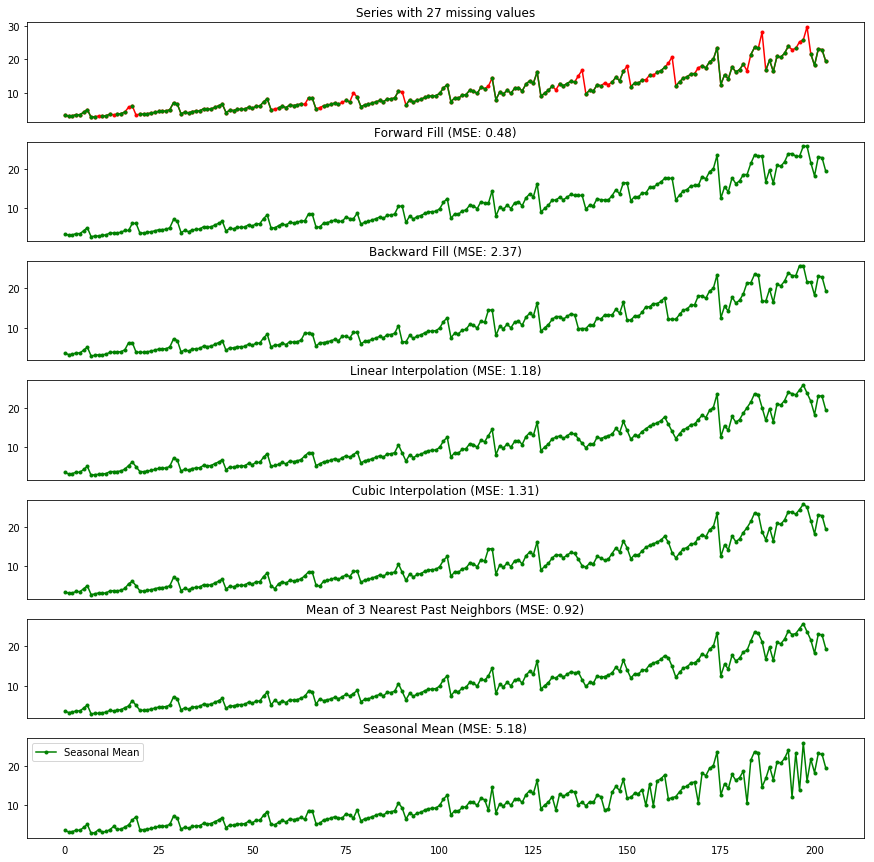

In [214]:
df_nan = df.reset_index()
random.seed(9001)
for i in set([randint(0, df_nan.shape[0]) for _ in range(30)]):
    df_nan.loc[i, 'value'] = np.nan

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(15, 15))
plt.rcParams.update({'xtick.bottom' : False})

# 1. Actual -------------------------------
axes[0].plot(df.value.values, '.-', color='red', label='Actual')
axes[0].plot(df_nan.value, '.-', color='green', label='Actual')
axes[0].set_title(f'Series with {df_nan.value.isna().sum()} missing values')

# 2. Forward Fill --------------------------
df_nan_ffill = df_nan.ffill()
error = np.round(mean_squared_error(df['value'], df_nan_ffill['value']), 2)
axes[1].plot(df_nan_ffill.value, '.-', color='green', label='Forward Fill')
axes[1].set_title(f'Forward Fill (MSE: {error})')

# 3. Backward Fill -------------------------
df_nan_bfill = df_nan.bfill()
error = np.round(mean_squared_error(df['value'], df_nan_bfill['value']), 2)
axes[2].plot(df_nan_bfill.value, '.-', color='green', label='Backward Fill')
axes[2].set_title(f'Backward Fill (MSE: {error})')

## 4. Linear Interpolation ------------------
df_nan['idx'] = np.arange(df_nan.shape[0])
df_nona = df_nan.dropna(subset=['value'])
f = interp1d(df_nona['idx'], df_nona['value'])
df_nan['linear_fill'] = f(df_nan['idx'])
error = np.round(mean_squared_error(df['value'], df_nan['linear_fill']), 2)
axes[3].plot(df_nan.linear_fill, '.-', color='green', label='Linear Interpolation')
axes[3].set_title(f'Linear Interpolation (MSE: {error})')

# 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['idx'], df_nona['value'], kind='cubic')
df_nan['cubic_fill'] = f2(df_nan['idx'])
error = np.round(mean_squared_error(df['value'], df_nan['cubic_fill']), 2)
axes[4].plot(df_nan.cubic_fill, '.-', color='green', label='Cubic Interpolation')
axes[4].set_title(f'Cubic Interpolation (MSE: {error})')

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

n = 3
df_nan['knn_mean'] = knn_mean(df_nan.value.values, n)
error = np.round(mean_squared_error(df['value'], df_nan['knn_mean']), 2)
axes[5].plot(df_nan.knn_mean, '.-', color='green', label='Cubic Interpolation')
axes[5].set_title(f'Mean of {n} Nearest Past Neighbors (MSE: {error})')

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df_nan['seasonal_mean'] = seasonal_mean(df_nan.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df['value'], df_nan['seasonal_mean']), 2)
axes[6].plot(df_nan.seasonal_mean, '.-', color='green', label='Seasonal Mean')
axes[6].set_title(f'Seasonal Mean (MSE: {error})')

plt.legend()
plt.show()

# What is autocorrelation and partial autocorrelation functions?

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

Autocorrelation coef [1.         0.92056815 0.88782519 0.85385862 0.84052841 0.82523769
 0.79629658 0.77950157 0.75953251 0.74337588 0.74521347 0.74134847
 0.78031252 0.71424686 0.68014097 0.65401657 0.63791893 0.62349882
 0.60171747 0.58230335 0.5638103  0.5502367  0.55428812 0.55963579
 0.5948865  0.5443742  0.5118496  0.49425977 0.48585482 0.47551253
 0.45600656 0.44259219 0.42927946 0.416305   0.4173017  0.41648248
 0.44663227 0.40084543 0.36925858 0.35321116 0.34468629 0.33615309
 0.31790639 0.30248802 0.2882186  0.27463544 0.2766393  0.27364256
 0.29913888 0.25730382 0.22818248]
Partial Autocorrelation coef [ 1.00000000e+00  9.25102966e-01  2.82971065e-01  7.59757971e-02
  1.69214944e-01  9.37032442e-02 -6.39607472e-02  5.60043953e-02
  1.65088238e-02  4.31903979e-03  1.74967636e-01  8.74246693e-02
  4.16356229e-01 -6.36840131e-01 -1.52234343e-01  1.03379843e-01
 -1.02461781e-01  4.61991378e-02  2.63314924e-01 -6.44713103e-02
 -5.88150504e-02  7.18477473e-02  6.52357282e-03  1.94

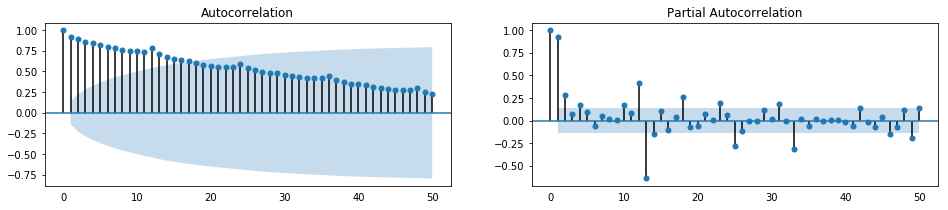

In [220]:
# Calculate ACF and PACF upto 50 lags
acf_50 = acf(df.value, nlags=50)
pacf_50 = pacf(df.value, nlags=50)
print('Autocorrelation coef', acf_50)
print('Partial Autocorrelation coef', pacf_50)

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])
plt.show()

### Lag Plots

A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series like the one below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

In below example on Sunspots area time series, the plots get more and more scattered as the n_lag increases.

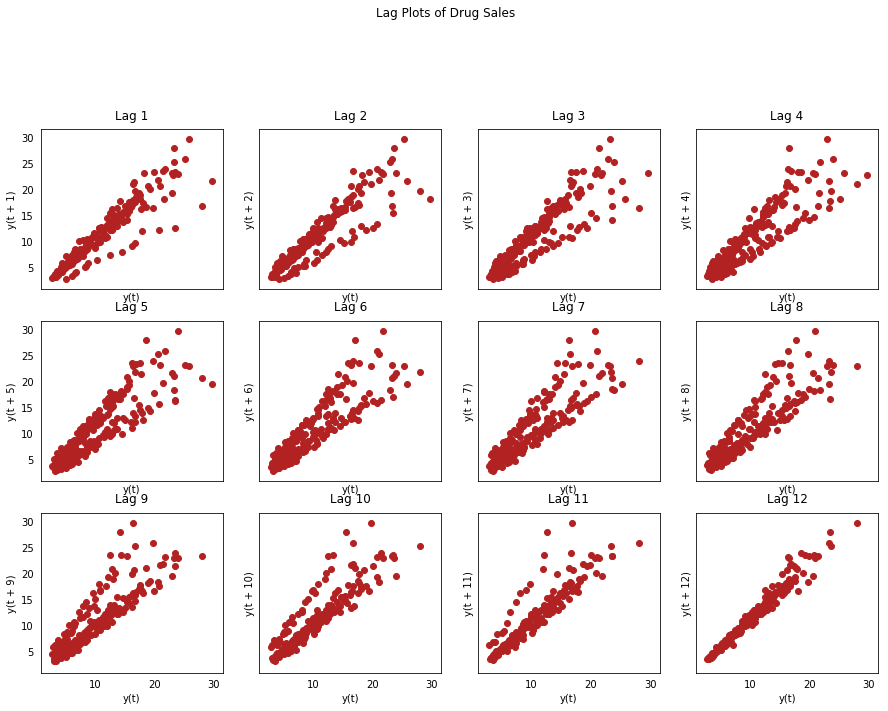

In [231]:
plt.rcParams.update({'ytick.left' : False})
# Plot
fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()[:12]):
    pd.plotting.lag_plot(df.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

### How to estimate the forecastability of a time series?

The more regular and repeatable patterns a time series has, the easier it is to forecast. The **[Approximate Entropy](https://en.wikipedia.org/wiki/Approximate_entropy)** can be used to quantify the *regularity* and *unpredictability* of fluctuations in a time series. The higher the approximate entropy, the more difficult it is to forecast it.

Another better alternate is the **[Sample Entropy](https://en.wikipedia.org/wiki/Sample_entropy)**. Sample Entropy is similar to approximate entropy but is more consistent in estimating the complexity even for smaller time series. For example, a random time series with fewer data points can have a lower *approximate entropy* than a more *regular* time series, whereas, a longer random time series will have a higher *approximate entropy*.

Sample Entropy handles this problem nicely. See the demonstration below.

In [233]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(df.value, m=2, r=0.2*df.value.std())) # 0.52
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.40
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big))) # 0.76

0.5287249271862344
0.40301845058393804
0.7605773744915121


In [235]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(df.value, m=2, r=0.2*df.value.std())) # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 2.77
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big))) # 2.41

0.41677970468814135
2.772588722239781
2.4159137783010487


### Why and How to smoothen a time series?